# Preprocessing: convert image and extract mask

## Example

This notebook shows how to convert (TCGA) svs file to a dense pyramid tif file.
Furthermore we show how to (naively) create a tissue-background mask

**The resulting .tif and _mask.tif files can be used in to run the HookNet-TLS algorithm.**


requirements:
 - numpy
 - pyvips
 - matplotlib
 - skimage
 - wholeslidedata

In [1]:
from pathlib import Path

import numpy as np
import pyvips
from matplotlib import pyplot as plt
from skimage import color
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes, remove_small_objects
from wholeslidedata import WholeSlideImage

## Converting to tif

First download the svs file from gdc portal: https://portal.gdc.cancer.gov/files/5e5ae252-aa14-4176-8306-185f4a7288d4

Convert the svs file to tif such that we get a dense pyramid, i.e., all spacings/mpps with a factor of two are available starting from specified spacing/mpp.

In this case we are going to convert the svs to tif starting from ~0.5. The actual/real spacing is determinded by the orginal svs file. As you will see below the actual spacing/mpp will be 0.5054047709815533. The tif will contain all down downsampled factor x2 levels, i.e., [0.505.., 1.010.., 2.0217.., 4.043..., 8.0876... etc]


**Run the following command (script is located in [wholeslidedata package](https://github.com/DIAGNijmegen/pathology-whole-slide-data))**

```bash
python ./wholeslidedata/scripts/save_image_at_spacing.py \
 -i "./TCGA-FD-A43N-01Z-00-DX1.57422C5F-A3A1-4595-9E06-C05C7FF5944B.svs" \
 -s 0.5
```

## Checking converted tif file

In [2]:
print("\nOriginal SVS\n---------")
wsi_svs = WholeSlideImage('./TCGA-FD-A43N-01Z-00-DX1.57422C5F-A3A1-4595-9E06-C05C7FF5944B.svs')
print("\tSpacings/MPPs: ", wsi_svs.spacings)
print("\tShapes: ", wsi_svs.shapes)

print("\nConverted TIF\n---------")
wsi_tif = WholeSlideImage('./converted_0-5/TCGA-FD-A43N-01Z-00-DX1.57422C5F-A3A1-4595-9E06-C05C7FF5944B.tif')
print("\tSpacings/MPPs: ", wsi_tif.spacings)
print("\tShapes: ", wsi_tif.shapes)



Original SVS
---------
	Spacings/MPPs:  [0.2527, 1.0108288130323653, 4.043468932039815, 8.087635020102077]
	Shapes:  ((121511, 92823), (30377, 23205), (7594, 5801), (3797, 2900))

Converted TIF
---------
	Spacings/MPPs:  [0.5054047709815533, 1.0108287508326805, 2.021734341602729, 4.043468683205458, 8.087634521503857, 16.17739941067229, 32.35479882134458, 64.7884157260767, 129.5768314521534, 260.42260993218076]
	Shapes:  ((60755, 46411), (30377, 23205), (15188, 11602), (7594, 5801), (3797, 2900), (1898, 1450), (949, 725), (474, 362), (237, 181), (118, 90))


## Creating background-tissue mask (naively)

Processing spacing:  8.087634521503857


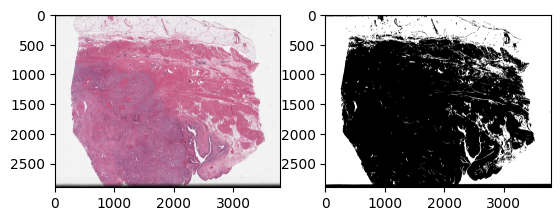

In [3]:
processing_spacing = 8.0
processing_spacing = wsi_tif.get_real_spacing(processing_spacing)
print("Processing spacing: ", processing_spacing)


processing_slide = wsi_tif.get_slide(processing_spacing)
grey_processing_slide = color.rgb2gray(processing_slide)

processing_slide_mask = grey_processing_slide > threshold_otsu(grey_processing_slide)
processing_slide_mask = remove_small_objects(processing_slide_mask)
processing_slide_mask = remove_small_holes(processing_slide_mask)

fig, ax = plt.subplots(1,2)
ax[0].imshow(processing_slide)
ax[1].imshow(processing_slide_mask,  cmap='gray')
plt.show()

## Saving mask to tif

In [4]:
tif_mask_spacing = 2.0
tif_mask_spacing = wsi_tif.get_real_spacing(tif_mask_spacing)
print("Tif mask spacing: ", tif_mask_spacing)

upsample_ratio = processing_spacing / tif_mask_spacing
print("Upsample ratio: ", upsample_ratio)


mask_img = pyvips.Image.new_from_array(processing_slide_mask)
mask_img_upscaled = mask_img.resize(upsample_ratio, kernel = pyvips.enums.Kernel.NEAREST)
print("Upscaled mask: ", mask_img_upscaled)

output_path = f"{Path(wsi_tif.path).stem}_mask.tif"
xres = tif_mask_spacing 
yres = tif_mask_spacing
mask_img_upscaled.tiffsave(
    output_path,
    compression="lzw",
    tile=True,
    tile_width=512,
    tile_height=512,
    pyramid=True,
    bitdepth=8,
    bigtiff=True,
    depth="onetile",
    background=[0],
    resunit="cm",           # NOTE: cm is required because "asap" backend wont work correctly with inch
    xres=1000/xres,
    yres=1000/yres,
)

Tif mask spacing:  2.021734341602729
Upsample ratio:  4.000344830217598
Upscaled mask:  <pyvips.Image 15189x11601 uchar, 1 bands, b-w>


## Check mask metadata


**NOTE:** Please note that opening the mask file with "openslide" or "asap" backend works OK to check metadata.

**However, only the "asap" backend is able to extract (patch/tile) data from the tif file.**


In [5]:
wsm = WholeSlideImage("./TCGA-FD-A43N-01Z-00-DX1.57422C5F-A3A1-4595-9E06-C05C7FF5944B_mask.tif")

print("Mask tif\n---------")
print("\tSpacings/MPPs: ", wsm.spacings)
print("\tShapes: ", wsm.shapes)

Mask tif
---------
	Spacings/MPPs:  [2.021734434915354, 4.043776271216344, 8.087552542432688, 16.177235609152888, 32.354471218305775, 64.78775883866919]
	Shapes:  ((15189, 11601), (7594, 5800), (3797, 2900), (1898, 1450), (949, 725), (474, 362))
